In [185]:
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords
from langdetect import detect


# Carica i dati
url = 'https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv'
df = pd.read_csv(url)
data = df['TweetText'].tolist()

stop_words_dict = {
    'en': set(stopwords.words('english')),     # Inglese
}


# Funzione per pulire i tweet
def clean_tweet(text):
    text =re.sub(r'http\S+|https\S+', '', text) # Rimuovere link
    text = re.sub(r'@(\w+)', '', text)    # Rimuovere menzioni (@username)
    text = re.sub(r'#\w+', '', text) # Rimuovere hashtag
    text = re.sub(r'[^\w\s]', '', text)# Rimuovere qualsiasi carattere che non sia alfanumerico o uno spazio
    text = text.lower() 
    
    return text


# Rimozione stopwords
def remove_stopwords(text, lang):
    if lang in stop_words_dict:
        stop_words = stop_words_dict[lang]
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    else:
        return ''

In [186]:
frase = "Yesterday sono andato al mercato to buy some fresh frutta and vegetables"
frase_cleaned = clean_tweet(frase)
l = detect(frase_cleaned)
frase_cleaned = remove_stopwords(frase_cleaned, l)
print(frase_cleaned)

yesterday sono andato al mercato buy fresh frutta vegetables


In [187]:
# Pre-elaborazione dei tweet
data_cleaned = []
for tweet in data:
    try:
        # Pulizia del tweet
        cleaned_tweet = clean_tweet(tweet)
        # Rileva la lingua
        lang = detect(cleaned_tweet)
        # Rimozione stop words in base alla lingua rilevata
        cleaned_tweet = remove_stopwords(cleaned_tweet, lang)
        if cleaned_tweet:  # Controlla se la stringa non è vuota
            data_cleaned.append(cleaned_tweet)
    except:
        continue  # Ignora tweet con errore nella rilevazione della lingua
print("Tweet originale:", data[:10])
print("Tweet pulito:", data_cleaned[:10])

Tweet originale: ['Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is', '@Apple will be adding more carrier support to the iPhone 4S (just announced)', "Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY", '@RIM you made it too easy for me to switch to @Apple iPhone. See ya!', 'I just realized that the reason I got into twitter was ios5 thanks @apple', "I'm a current @Blackberry user, little bit disappointed with it! Should I move to @Android or @Apple @iphone", 'The 16 strangest things Siri has said so far. I am SOOO glad that @Apple gave Siri a sense of humor! http://t.co/TWAeUDBp via @HappyPlace', 'Great up close & personal event @Apple tonight in Regent St store!', 'From which companies do you experience the best customer service aside from @zappos and @apple?', 'Just apply for a job at @Apple, hope they call me lol']
Tweet pulito: ['get swype iphone crack iphone', 'adding c

In [188]:
# Lemmatizzazione - Carica modelli per ogni lingua
nlp_models = {
    'en': spacy.load("en_core_web_sm"),
}

def lemmatize_text(text, lang):
    if lang in nlp_models:
        doc = nlp_models[lang](text)
        return ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return text  # Restituisce il testo originale se non è supportato

# Lemmatizzazione dei dati puliti
data_lemmatized = []
for tweet in data_cleaned:
    try:
        lang = detect(tweet)
        lemmatized_tweet = lemmatize_text(tweet, lang)
        data_lemmatized.append(lemmatized_tweet)
    except:
        continue 
        
data_lemmatized = [tweet for tweet in data_lemmatized if isinstance(tweet, str) and tweet]
print("Tweet lemmatizzati:", data_lemmatized[:10])
print("Numero di tweet lemmatizzati:", len(data_lemmatized))

Tweet lemmatizzati: ['swype iphone crack iphone', 'add carrier support iphone 4s announce', 'hilarious video guy duet siri pretty sum love affair', 'easy switch iphone ya', 'realize reason get twitter ios5 thank', 'm current user little bit disappointed', '16 strangest things siri said far sooo glad gave siri sense humor via', 'great close personal event tonight regent st store', 'company experience good customer service aside', 'apply job hope lol']
Numero di tweet lemmatizzati: 3301


In [189]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [190]:
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

b_topic_model = BERTopic(nr_topics =10)
b_topics, probabilities = b_topic_model.fit_transform(data_cleaned)

b_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1278,-1_rt_new_iphone_get,"[rt, new, iphone, get, know, time, sandwich, a...",[android 40 ice cream sandwich google nexus ne...
1,0,861,0_rt_steve_ballmer_store,"[rt, steve, ballmer, store, twitter, im, follo...",[ceo steve ballmer buying sometimes youre luck...
2,1,552,1_iphone_phone_siri_new,"[iphone, phone, siri, new, nexus, 4s, galaxy, ...","[ipod touch get hello world baby memories app,..."
3,2,289,2_bookcase_rt_asiaclassifiedtoday_touchscreen,"[bookcase, rt, asiaclassifiedtoday, touchscree...","[releases infinite digital bookcase rt, rt rel..."
4,3,165,3_cream_sandwich_ice_nexus,"[cream, sandwich, ice, nexus, galaxy, android,...","[ice cream sandwich android, ice cream sandwic..."
5,4,97,4_search_google_go_searches,"[search, google, go, searches, googles, defaul...","[google go, google go, google begin encrypting..."
6,5,20,5_minutes_age_seconds_days,"[minutes, age, seconds, days, hours, find, yea...",[age 2 years 153 days 5 hours 6 minutes 25 sec...
7,6,15,6_roslyn_compiler_preview_developer,"[roslyn, compiler, preview, developer, project...",[rt microsoft releases developer preview proje...
8,7,13,7_antitrust_racketeering_played_outlaws,"[antitrust, racketeering, played, outlaws, law...",[violated us antitrust lawsleaving business wo...
9,8,12,8_buzz_movement_charts_builds,"[buzz, movement, charts, builds, occupy, wall,...",[buzz builds occupy wall street movement chart...


In [191]:
bert_topics = b_topic_model.get_topics()
# Preparare i dati per Gensim
topic_w = [doc.split() for doc in data_cleaned]
bert_id2word = Dictionary(topic_w)
bert_corpus = [bert_id2word.doc2bow(text) for text in topic_w]

In [192]:
b_topic_model.visualize_barchart(top_n_topics=10)

In [193]:
b_topic_model.visualize_topics()


In [194]:
from g2t.graph2topictm import evaluate

td_score, cv_score, npmi_score = evaluate(data_cleaned, b_topics, bert_topics)
print(f"Diversità dei temi: {td_score}, Coerenza c_v: {cv_score}, Coerenza NPMI: {npmi_score}")

Diversità dei temi: 0.87, Coerenza c_v: 0.6477012926563732, Coerenza NPMI: 0.181175682792133


In [195]:
from g2t.graph2topictm import Graph2TopicTM
from g2t.graph2topictm import _calculate_topic_diversity, _calculate_cv_npmi

tm = Graph2TopicTM(dataset=data_cleaned, 
                embedding='princeton-nlp/unsup-simcse-bert-base-uncased')
g2T_prediction = tm.train()
g2T_topics = tm.get_topics()
print(f'Topics: {g2T_topics}')

# Evaluate
g2T_td = _calculate_topic_diversity(g2T_topics)
g2T_cv, g2T_npmi = _calculate_cv_npmi(data_cleaned, g2T_prediction, g2T_topics)

# Print the results
print(f"Topic Diversity Score: {g2T_td}")
print(f"Coherence (c_v) Score: {g2T_cv}")
print(f"Coherence (NPMI) Score: {g2T_npmi}")

Initialize G2T with num_topics=10, embedding=princeton-nlp/unsup-simcse-bert-base-uncased, dim_size=5, graph_method=greedy_modularity
---creating embedding---


3302it [10:16,  5.35it/s]


---Detect 73 Topcis---
====== Using TFIDF_IDFi ======
Topics: {0: [('fuck', 0.007330447910761258), ('shit', 0.0071979767804894535), ('bitch', 0.005570043822736867), ('bad', 0.005392004944459628), ('im', 0.005349618604668743), ('fucking', 0.004873143209268788), ('hell', 0.004639693560983827), ('dont', 0.004504619533749894), ('damn', 0.0035053971752111723), ('problem', 0.003296140246890563)], 1: [('ios', 0.012311562715850852), ('phone', 0.010537128224200566), ('iphone', 0.009796523534952811), ('battery', 0.008549168449482076), ('better', 0.008518946530367543), ('store', 0.006689093088330821), ('wait', 0.006631954736094695), ('new', 0.006165945482048506), ('tomorrow', 0.005990351215425598), ('apple', 0.005818467925914647)], 2: [('presentations', 0.008844432049740182), ('business', 0.008066212314310333), ('social', 0.006843780312516036), ('webinar', 0.006692814789105343), ('development', 0.006653448177751777), ('best', 0.006399789657001955), ('partner', 0.006362463181808652), ('docs', 0.00

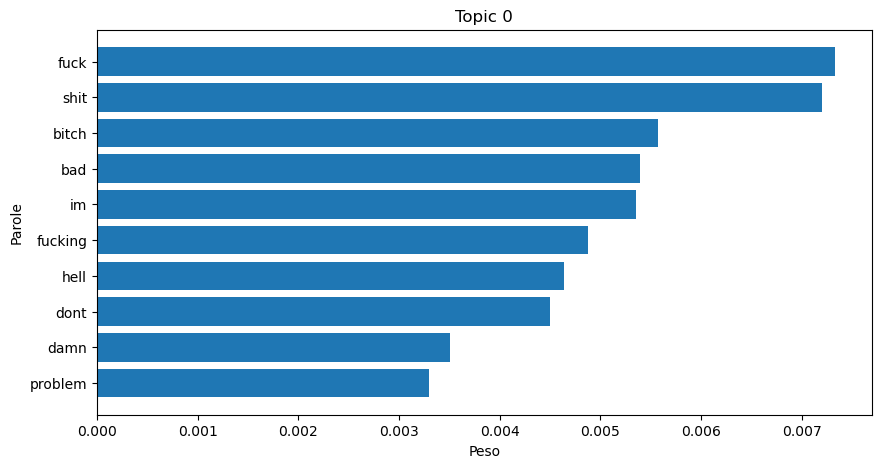

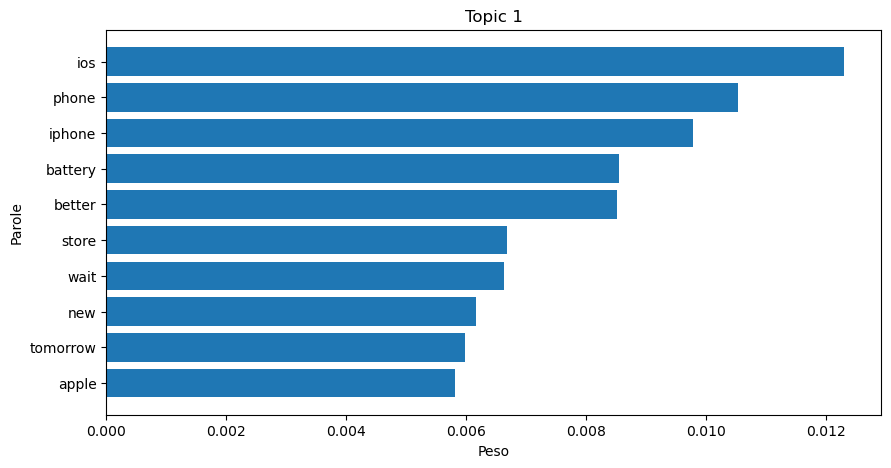

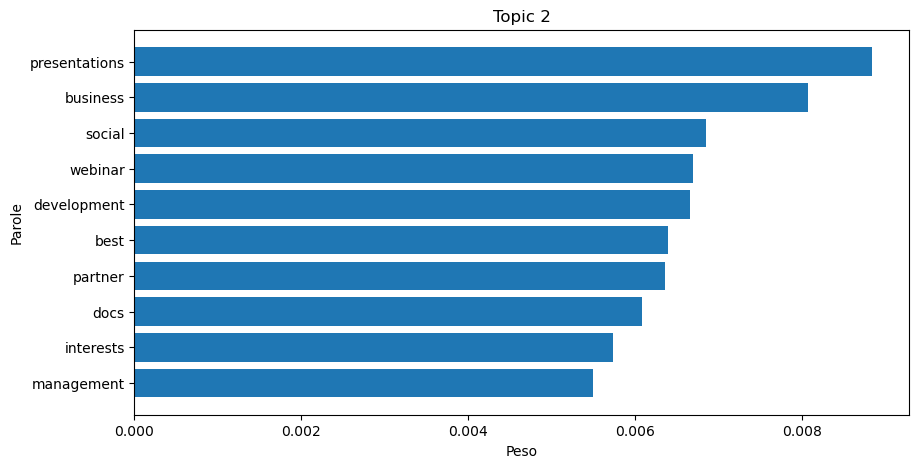

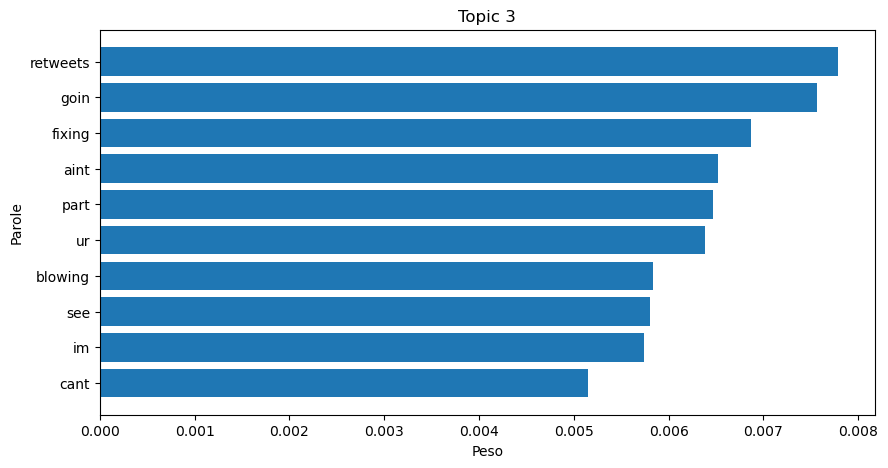

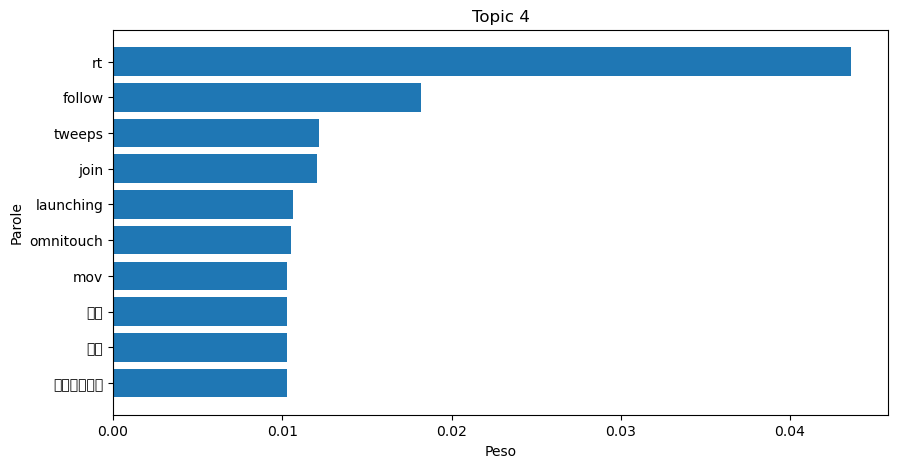

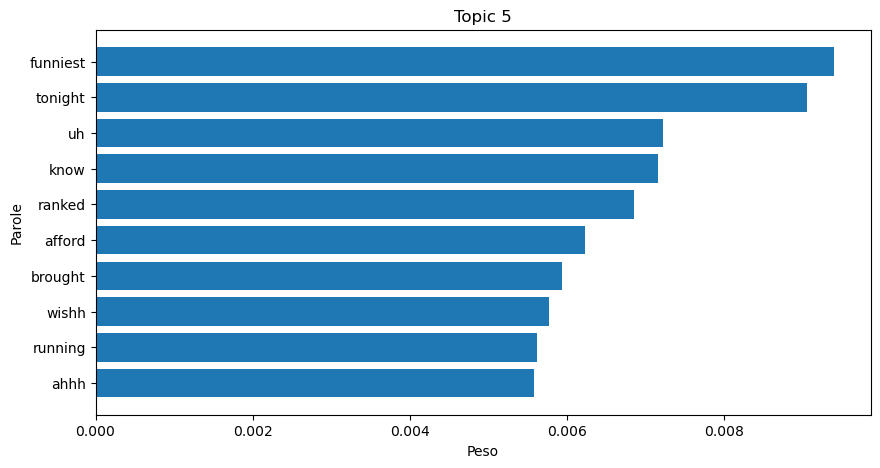

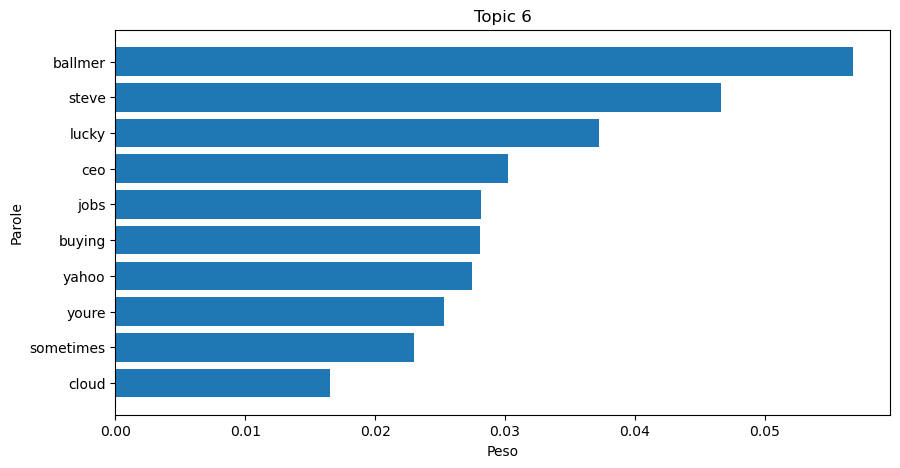

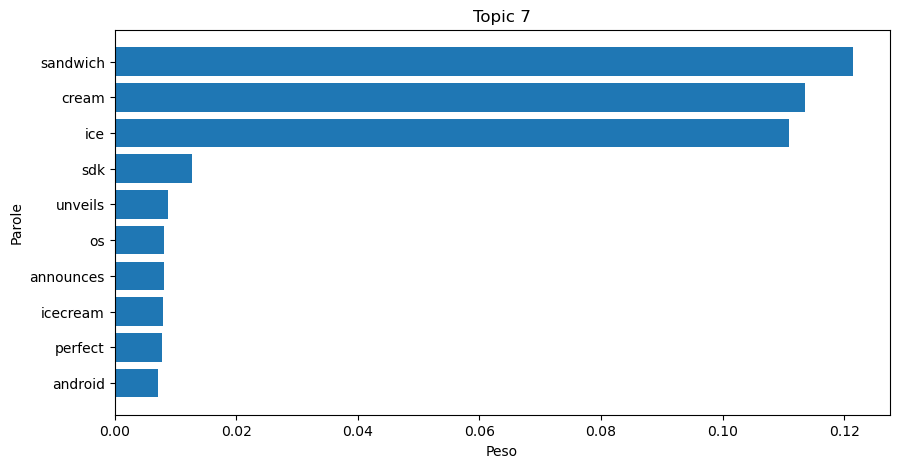

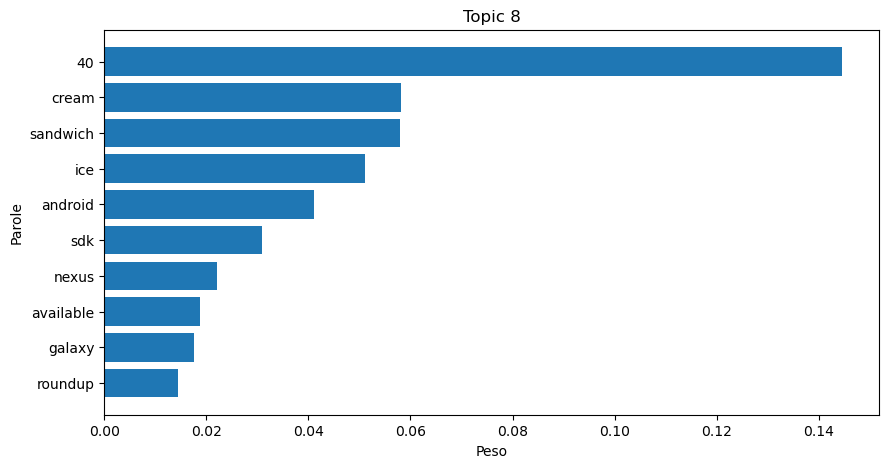

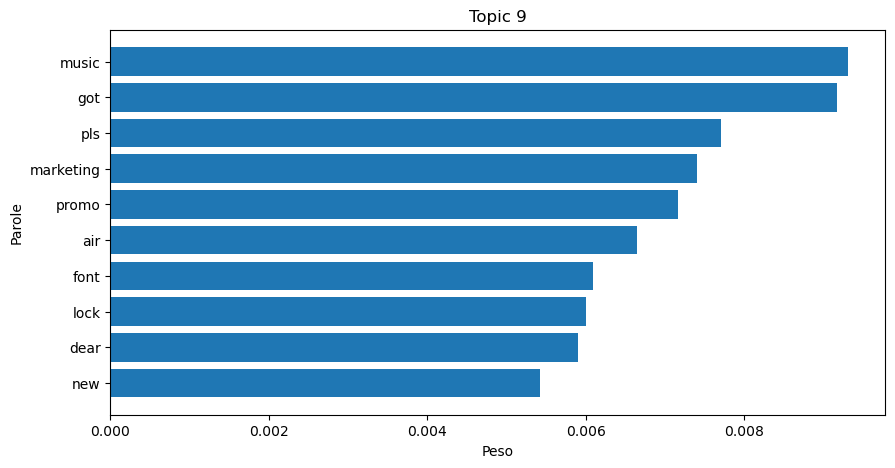

In [196]:
from plot_topics import plot_topics
plot_topics(g2T_topics)

In [197]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from pprint import pprint



# Funzione per convertire le frasi in parole
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


# Accedi correttamente alla colonna
data_words = list(sent_to_words(data_lemmatized))


# Visualizza i primi 30 termini del primo documento
print(data_words[:1][0][:30])



['swype', 'iphone', 'crack', 'iphone']


In [198]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Creare il corpus BoW
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, 1), (1, 2), (2, 1)]
[(0,
  '0.023*"rt" + 0.010*"great" + 0.010*"iphone" + 0.007*"thank" + 0.006*"app" + '
  '0.006*"sandwich" + 0.006*"android" + 0.006*"time" + 0.006*"good" + '
  '0.005*"new"'),
 (1,
  '0.025*"rt" + 0.013*"new" + 0.011*"nexus" + 0.010*"not" + 0.009*"phone" + '
  '0.009*"galaxy" + 0.008*"iphone" + 0.008*"sandwich" + 0.008*"good" + '
  '0.008*"app"'),
 (2,
  '0.021*"new" + 0.018*"cream" + 0.018*"ice" + 0.015*"sandwich" + '
  '0.014*"nexus" + 0.013*"galaxy" + 0.013*"phone" + 0.011*"not" + '
  '0.008*"google" + 0.007*"android"'),
 (3,
  '0.021*"iphone" + 0.014*"rt" + 0.010*"great" + 0.009*"get" + 0.007*"store" + '
  '0.006*"good" + 0.006*"not" + 0.006*"apple" + 0.005*"million" + '
  '0.005*"sell"'),
 (4,
  '0.022*"rt" + 0.009*"not" + 0.009*"new" + 0.007*"sandwich" + 0.007*"apple" + '
  '0.007*"cream" + 0.006*"ice" + 0.006*"phone" + 0.006*"ballmer" + '
  '0.006*"android"'),
 (5,
  '0.037*"rt" + 0.018*"new" + 0.012*"ice" + 0.012*"cream" + 0.012*"sandwich" + '
  '0.010*

In [199]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# Prepara i dati per la visualizzazione
LDAvis_prepared = gensimvis.prepare(lda_model, corpus,id2word)

# Visualizza i dati preparati
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.069249  0.099008       1        1  13.463758
5      0.010632 -0.056535       2        1  12.702799
2     -0.037125 -0.077967       3        1  11.910072
1     -0.041797 -0.033170       4        1  10.142979
9      0.038975 -0.056257       5        1   9.388251
7     -0.075629  0.000660       6        1   9.341207
0      0.087548  0.043830       7        1   8.710829
4      0.021707 -0.023606       8        1   8.457669
6     -0.025075  0.063176       9        1   8.242143
3      0.090015  0.040861      10        1   7.640292, topic_info=          Term        Freq       Total Category  logprob  loglift
63          rt  389.000000  389.000000  Default  30.0000  30.0000
1       iphone  173.000000  173.000000  Default  29.0000  29.0000
1686     cream  153.000000  153.000000  Default  28.0000  28.0000
1687       ice  147.000000  147.000000  Default  27.0000  27.0000
42       great   68.000000   68.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1709    galaxy    6.444432  106.714123  Topic10  -5.5379  -0.2352
11        love    5.682561   59.581065  Topic10  -5.6637   0.2218
139        day    5.682552   67.064757  Topic10  -5.6637   0.1035
151      phone    6.503681  177.730177  Topic10  -5.5287  -0.7362
1688  sandwich    5.682483  155.329227  Topic10  -5.6637  -0.7364

[784 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3393      6  0.858868     acct
3934      2  0.308077  acquire
3934     10  0.616153  acquire
1774      4  0.827053      act
4334      9  0.839674   acting
...     ...       ...      ...
2094      2  0.206551       記録
2094      9  0.619654       記録
2095      1  0.206348       銀座
2095      2  0.206348       銀座
2095      9  0.619043       銀座

[1942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 3, 2, 10, 8, 1, 5, 7, 4])

In [200]:
predictions = []
for doc in corpus:
    topic_probs = lda_model.get_document_topics(doc)
    # Extract the topic with the highest probability
    # If no topic, assign -1
    if topic_probs:
        predictions.append(max(topic_probs, key=lambda x: x[1])[0])
    else:
        predictions.append(-1)

# Create a dictionary to map topics to words and their weights
lda_topics = {}
for topic_id in range(num_topics):
    words = lda_model.get_topic_terms(topic_id, topn=10)  # Get top 10 words for each topic
    lda_topics[topic_id] = [(id2word[word_id], weight) for word_id, weight in words]

td_lda, cv_lda, npmi_lda = evaluate(data_lemmatized, predictions, lda_topics)
print(f"Diversità dei temi: {td_lda}, Coerenza c_v: {cv_lda}, Coerenza NPMI: {npmi_lda}")

Diversità dei temi: 0.31, Coerenza c_v: 0.40851069627262493, Coerenza NPMI: 0.022277578227072183


In [201]:
lda_model.get_document_topics(doc)

[(0, 0.7749513),
 (1, 0.025007496),
 (2, 0.025003731),
 (3, 0.025003335),
 (4, 0.025005765),
 (5, 0.025013926),
 (6, 0.025003916),
 (7, 0.02500485),
 (8, 0.025002869),
 (9, 0.025002869)]

In [202]:
import Bert_LDA
import importlib  # Importa importlib
importlib.reload(Bert_LDA) 

<module 'Bert_LDA' from '/Users/hongyuxu/Downloads/implementazioni Topic/Bert_LDA.py'>

In [203]:
from Bert_LDA import Topic_Model
from Bert_LDA import get_token_lists

token_lists = get_token_lists(data_lemmatized)
bertlda_m = Topic_Model(method='LDA_BERT')
bertlda_m.fit(data_lemmatized, token_lists)

Clustering embeddings ...
Getting vector representations for LDA ...
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
104/104 [==============================] - 1s 3ms/step
Clustering embeddings. Done!


Calculating UMAP projection...
Calculating the Umap projection. Done!


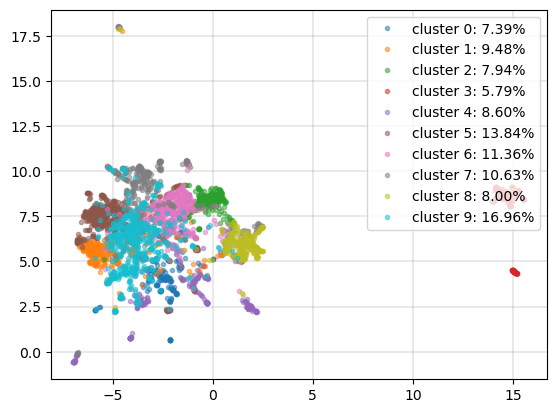

In [204]:
from Bert_LDA import visualize
visualize(bertlda_m)

Getting wordcloud for topic 0 ...


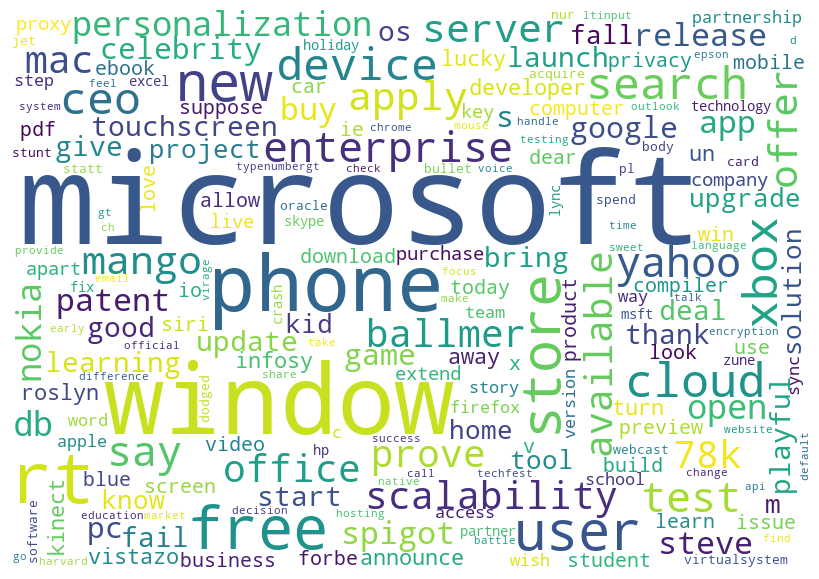

Getting wordcloud for topic 1 ...


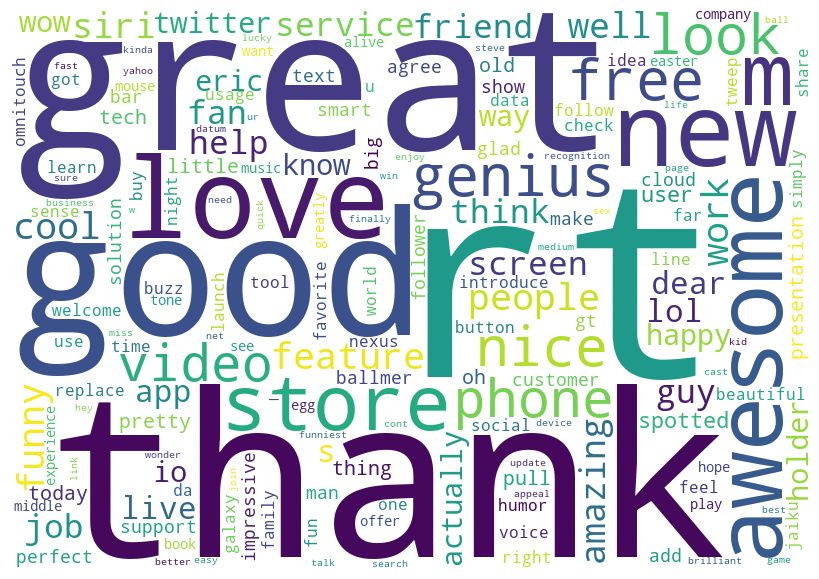

Getting wordcloud for topic 2 ...


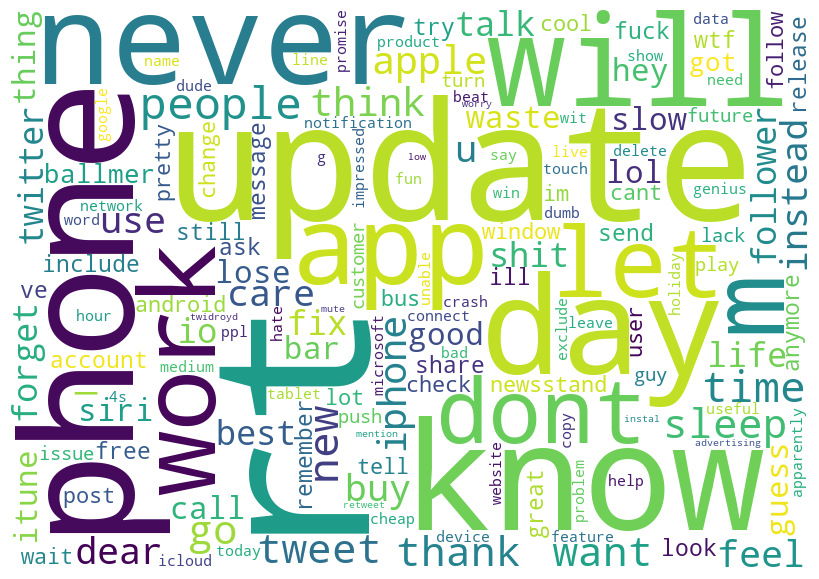

Getting wordcloud for topic 3 ...


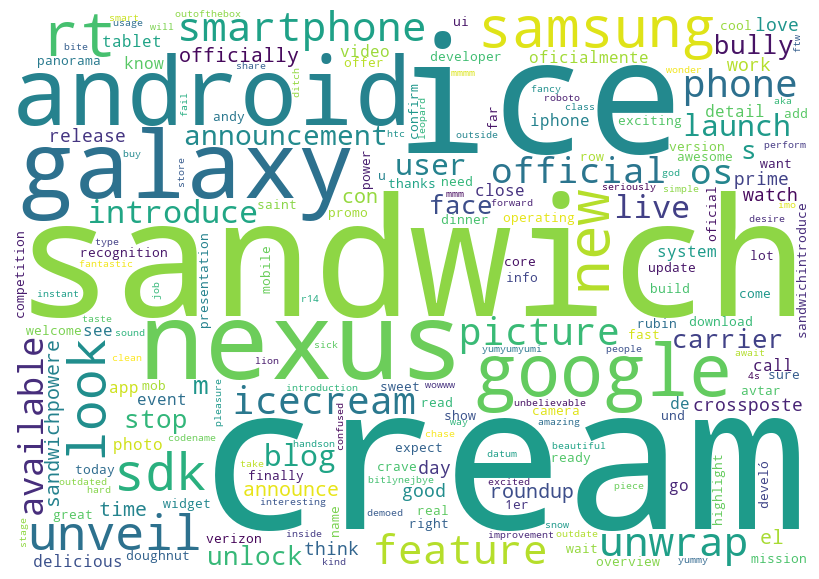

Getting wordcloud for topic 4 ...


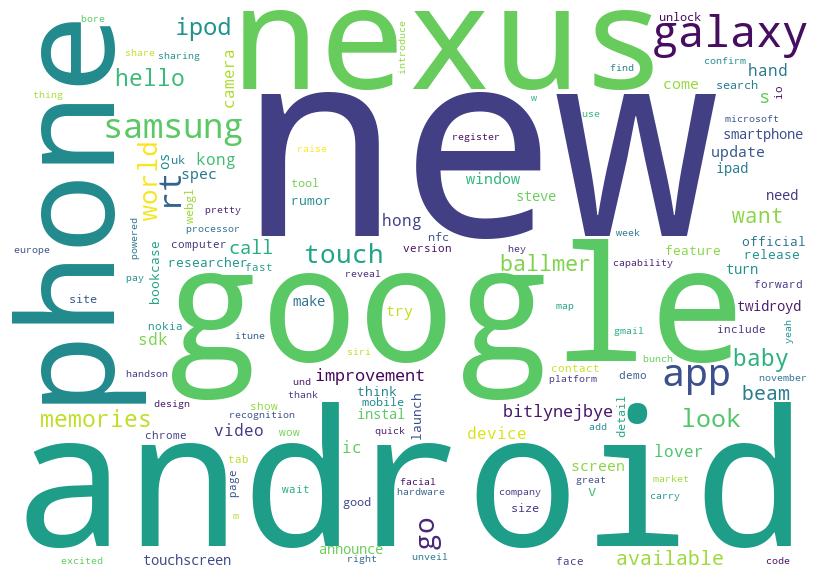

Getting wordcloud for topic 5 ...


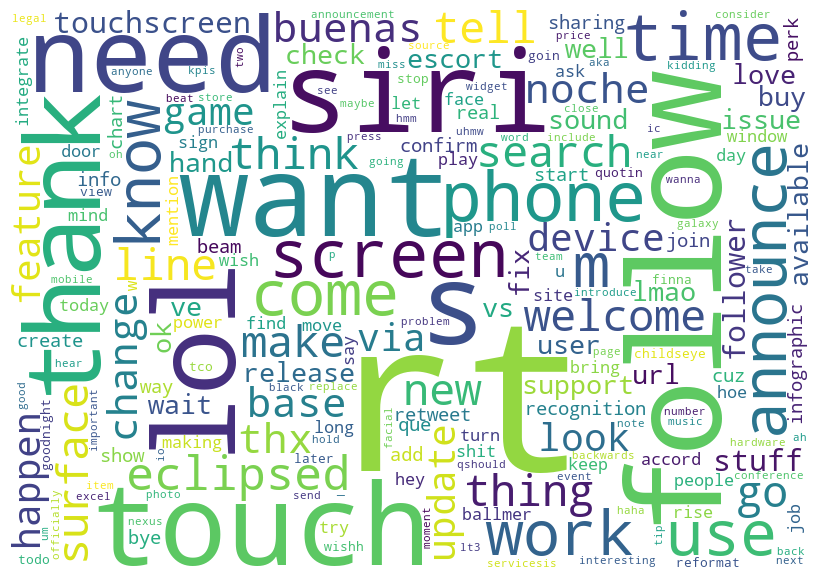

Getting wordcloud for topic 6 ...


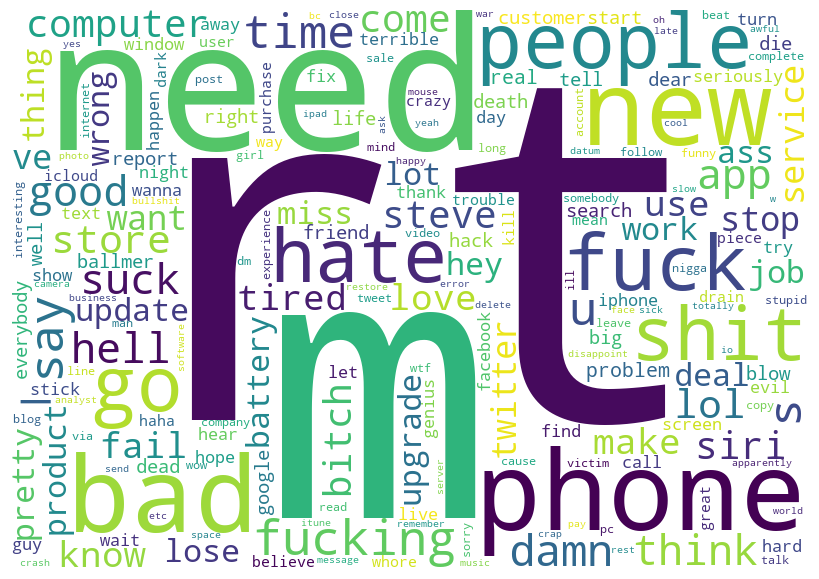

Getting wordcloud for topic 7 ...


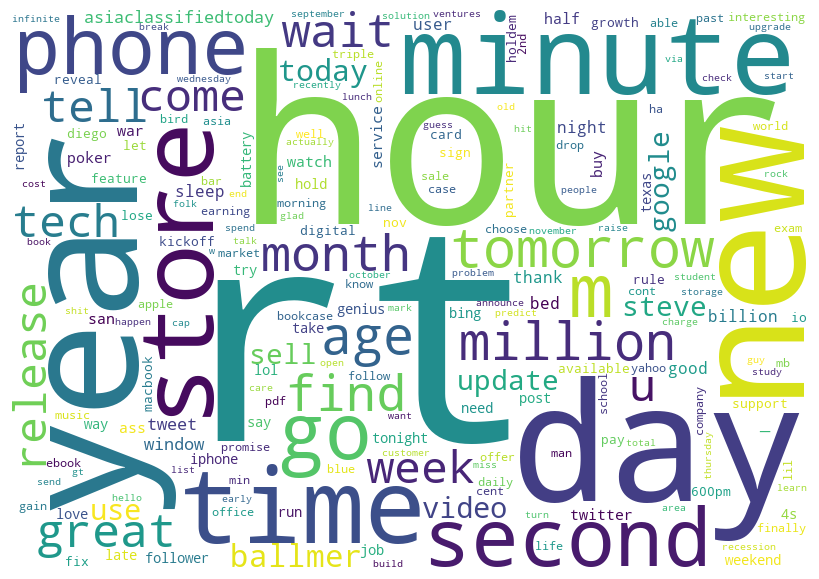

Getting wordcloud for topic 8 ...


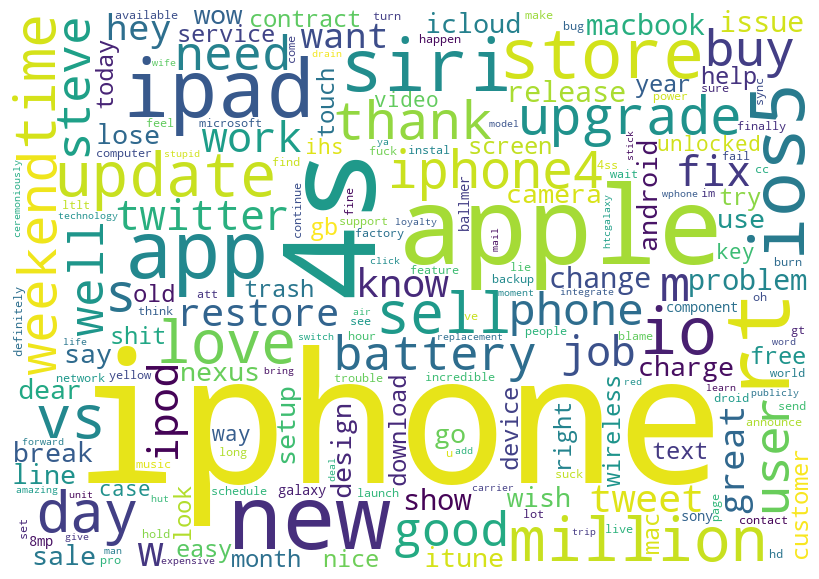

Getting wordcloud for topic 9 ...


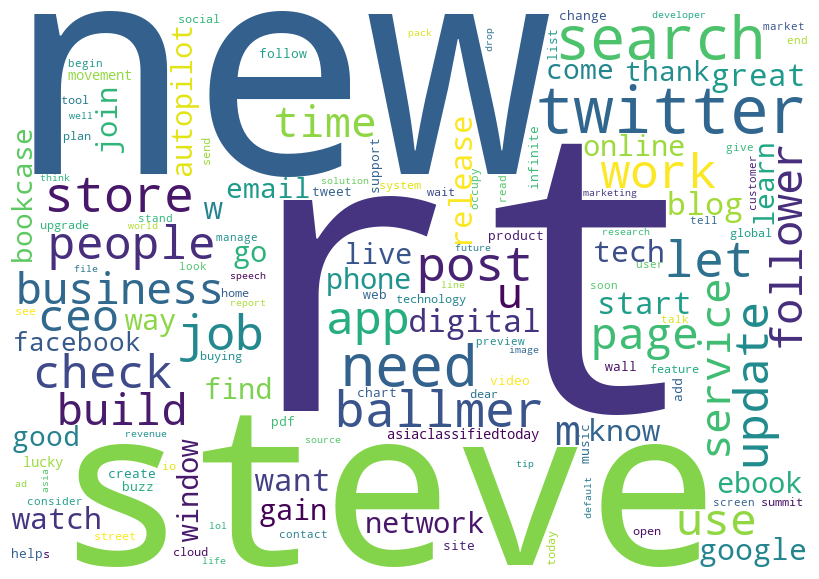

In [205]:
from Bert_LDA import get_wordcloud
for i in range(bertlda_m.k):
        get_wordcloud(bertlda_m, token_lists, i)

In [206]:
from Bert_LDA import get_topic_words

ldabert_dict= {}
ldabert_topics = get_topic_words(token_lists, bertlda_m.cluster_model.labels_)

for i in range(bertlda_m.k):
    ldabert_dict[i] = ldabert_topics[i]


print(ldabert_dict)

{0: ['microsoft', 'window', 'phone', 'rt', 'free', 'windows', 'store', 'user', 'new', 'xbox'], 1: ['rt', 'great', 'good', 'thank', 'love', 'new', 'awesome', 'like', 'm', 'store'], 2: ['not', 'rt', 'update', 'like', 'phone', 'know', 'day', 'will', 'never', 'app'], 3: ['cream', 'sandwich', 'ice', 'nexus', 'android', 'galaxy', '40', 'google', 'rt', 'new'], 4: ['new', 'android', 'google', 'nexus', 'phone', 'galaxy', 'app', 'samsung', '40', 'rt'], 5: ['rt', 'like', 'follow', 'get', 'lol', 'siri', 's', 'want', 'touch', 'thank'], 6: ['rt', 'm', 'need', 'phone', 'bad', 'get', 'people', 'fuck', 'go', 'hate'], 7: ['rt', 'hour', 'year', 'day', 'new', 'minute', 'store', 'time', 'second', 'go'], 8: ['iphone', '4s', 'apple', 'rt', 'new', '4', 'ipad', 'app', 'ios5', 'siri'], 9: ['rt', 'new', 'steve', 'twitter', 'search', 'need', 'store', 'ballmer', 'post', 'let']}


In [207]:
from g2t.graph2topictm import _calculate_topic_diversity
from Bert_LDA import get_coherence_cv
from Bert_LDA import get_coherence_npmi

td_ldaBERT = _calculate_topic_diversity(ldabert_dict)
cv_ldaBERT = get_coherence_cv(bertlda_m, token_lists)
npmi_ldaBERT = get_coherence_npmi(bertlda_m, token_lists)

print(f"Diversità dei temi: {td_ldaBERT}, Coerenza c_v: {cv_ldaBERT}, Coerenza NPMI: {npmi_ldaBERT}")

Diversità dei temi: 0.21, Coerenza c_v: 0.3953342680375793, Coerenza NPMI: -0.016904107180898433


In [208]:
data = {
    'LDA_BERT': [td_ldaBERT, cv_ldaBERT, npmi_ldaBERT],
    'Graph2Topic': [g2T_td, g2T_cv, g2T_npmi],
    'BERTopic': [td_score, cv_score, npmi_score],
    'LDA' : [td_lda, cv_lda, npmi_lda]
}

# Creazione del DataFrame e impostazione delle righe
df = pd.DataFrame(data, index=['td', 'cv', 'npmi'])

# Visualizzazione della tabella
df


,LDA_BERT,Graph2Topic,BERTopic,LDA
td,0.210000,0.930000,0.870000,0.310000
cv,0.395334,0.647443,0.647701,0.408511
npmi,-0.016904,-0.020635,0.181176,0.022278


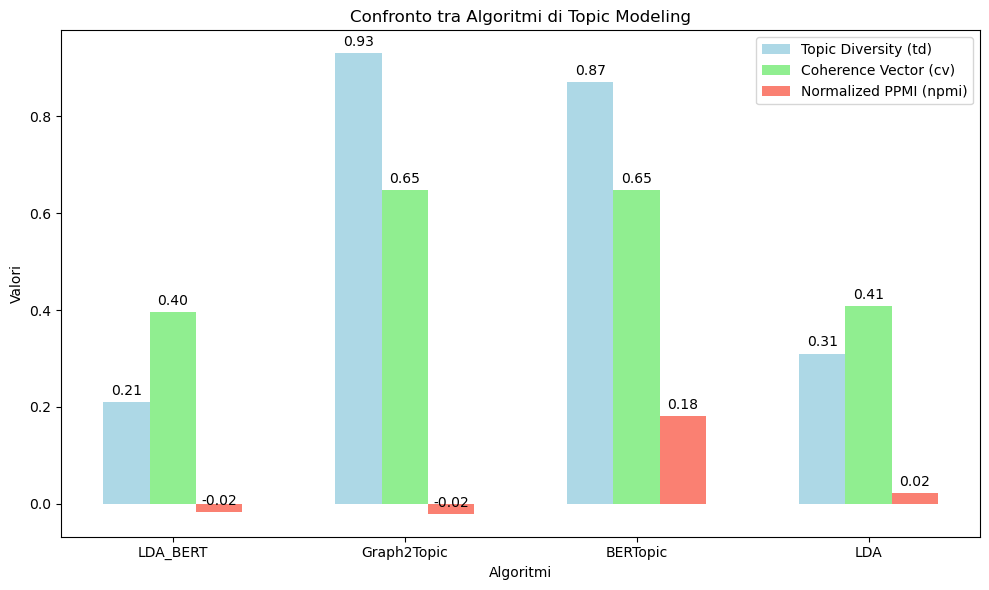

In [209]:
import matplotlib.pyplot as plt
import numpy as np

# Definisco i dati
algorithms = ['LDA_BERT', 'Graph2Topic', 'BERTopic', 'LDA']
td = [td_ldaBERT, g2T_td, td_score, td_lda]
cv = [cv_ldaBERT, g2T_cv, cv_score, cv_lda]
npmi = [npmi_ldaBERT, g2T_npmi, npmi_score, npmi_lda]

# Posizioni delle barre
x = np.arange(len(algorithms))

# Larghezza delle barre
width = 0.2

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 6))

# Creazione delle barre
bars1 = ax.bar(x - width, td, width, label='Topic Diversity (td)', color='lightblue')
bars2 = ax.bar(x, cv, width, label='Coherence Vector (cv)', color='lightgreen')
bars3 = ax.bar(x + width, npmi, width, label='Normalized PPMI (npmi)', color='salmon')

# Aggiunta delle etichette e titolo
ax.set_xlabel('Algoritmi')
ax.set_ylabel('Valori')
ax.set_title('Confronto tra Algoritmi di Topic Modeling')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

# Aggiunta delle etichette sopra le barre
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punti sopra la barra
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Mostrare il grafico
plt.tight_layout()
plt.show()
